In [36]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


데이터 증강시키고 훈련해보기

In [38]:
import os, shutil
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models

In [39]:
# 훈련 데이터 경로
train_dir = '/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/train'
# test 데이터 경로
test_dir = '/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/test'

In [47]:
# 파라미터

BATCH_SIZE = 3 # 배치 크기
ITER = 100 # 한 epoch에 배치를 몇개 처리할 건지(우리는 augmantation 적용 중이라 꼭 데이터 수에 안 맞춰도 되는 걸로 알고 있음)
EPOCHS = 30 # 전체 데이터에 대한 훈련 수
VAL_STEPS = 20 # 몇 번에 한번 검증할 건지

In [48]:
def invert(image):
    new_img = 255 - image
    return new_img

def preprocess(img):
  img = invert(img)
  img[img < np.mean(img)*2] = 0
  if np.max(img) <210:
    w = (200-np.max(img))*0.1
    img[img > np.mean(img)*2] *= w
  img[img>255] = 255
  return img

train_datagen = ImageDataGenerator(rescale=1./255,
                                    width_shift_range=5,
                                    height_shift_range=5,
                                    rotation_range=30,
                                    zoom_range=0.3,
                                    validation_split=0.2,
                                    preprocessing_function=preprocess)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(28, 28),
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training')
val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(28, 28),
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(28, 28),
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 423 images belonging to 10 classes.
Found 102 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


(3, 10)
label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


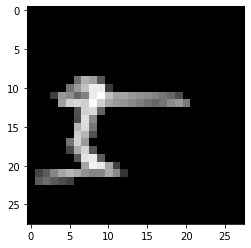

In [49]:
x_train, y_train = train_generator.next()
print(y_train.shape)
for i in range(1):
  print('label:', y_train[i])
  im = np.squeeze(x_train[i])
  plt.imshow(im, cmap='gray')
  plt.show()

In [50]:
!pip install autokeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **모델 설정

In [51]:
# 모델 구성

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [52]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
history = model.fit(
      train_generator,
      steps_per_epoch=ITER,
      epochs=EPOCHS,
      validation_data=val_generator,
      validation_steps=VAL_STEPS)

Epoch 1/30
100/100 [==============================] - 2s 15ms/step - loss: 2.3045 - accuracy: 0.0900 - val_loss: 2.2807 - val_accuracy: 0.1667
Epoch 2/30
100/100 [==============================] - 1s 12ms/step - loss: 2.2854 - accuracy: 0.1433 - val_loss: 2.2637 - val_accuracy: 0.1000
Epoch 3/30
100/100 [==============================] - 1s 13ms/step - loss: 2.2059 - accuracy: 0.1867 - val_loss: 1.9287 - val_accuracy: 0.2667
Epoch 4/30
100/100 [==============================] - 2s 18ms/step - loss: 2.1118 - accuracy: 0.2533 - val_loss: 1.8351 - val_accuracy: 0.3667
Epoch 5/30
100/100 [==============================] - 2s 20ms/step - loss: 1.9006 - accuracy: 0.3400 - val_loss: 1.8100 - val_accuracy: 0.3000
Epoch 6/30
100/100 [==============================] - 2s 20ms/step - loss: 1.7997 - accuracy: 0.3400 - val_loss: 1.8018 - val_accuracy: 0.3833
Epoch 7/30
100/100 [==============================] - 2s 19ms/step - loss: 1.7852 - accuracy: 0.3933 - val_loss: 1.7464 - val_accuracy: 0.4000

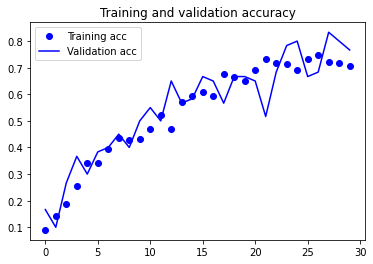

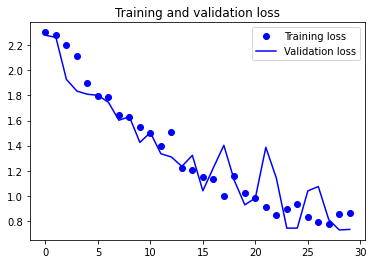

In [54]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [55]:
test_generator.reset()

print("-- Evaluate --")
scores = model.evaluate(test_generator, steps=int(200/BATCH_SIZE))
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

wrong_predict = []
for i in range(10):
  wrong_predict.append([])


-- Evaluate --
66/66 [==============================] - 1s 8ms/step - loss: 0.3620 - accuracy: 0.8889
accuracy: 88.89%


In [56]:
print("-- Predict --")
for j in range(int(200/BATCH_SIZE)):
  x_val,y_val = test_generator.next()
  y_pred = model.predict(x_val)
  for i in range(len(y_pred)):
    predict = np.argmax(y_pred[i])
    y_true = np.argmax(y_val[i])
    if predict != y_true:
      wrong_predict[y_true].append(predict)
for idx, pred in enumerate(wrong_predict):
  print(idx,'에 대한 오답 수:', len(pred))
  if pred:
    print(' - 오답들: ', pred)
  print()

-- Predict --
0 에 대한 오답 수: 1
 - 오답들:  [8]

1 에 대한 오답 수: 2
 - 오답들:  [0, 0]

2 에 대한 오답 수: 2
 - 오답들:  [4, 0]

3 에 대한 오답 수: 3
 - 오답들:  [7, 9, 2]

4 에 대한 오답 수: 2
 - 오답들:  [8, 9]

5 에 대한 오답 수: 1
 - 오답들:  [9]

6 에 대한 오답 수: 7
 - 오답들:  [8, 8, 8, 8, 8, 8, 0]

7 에 대한 오답 수: 0

8 에 대한 오답 수: 2
 - 오답들:  [0, 9]

9 에 대한 오답 수: 3
 - 오답들:  [4, 8, 1]

